In [130]:

import os 
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import ta
import talib
from statsmodels.tsa.stattools import adfuller
import vectorbt as vbt 


from technical_analysis import *
from ALGO_KT1 import Preprocessing_functions as prf

ticker = 'ALGOUSD'

timeframe = 60

df = pd.read_csv(f'C:/Users/User/Desktop/crypto_data/OHLCVT/Q1_2024/{ticker}_{timeframe}_v1.csv')

df.columns = df.columns.str.capitalize()

df = df.set_index('Timestamp')

print('Start: ',df.index.min())
print('End: ',df.index.max())

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/User/Desktop/crypto_data/OHLCVT/Q1_2024/ALGOUSD_60_v1.csv'

In [142]:
ticker = "JPM"
df = prf.downlaod_symbol_data(ticker, period = "240mo")

#df = ROC(df)
#df = EMA(df)
#df = momentum_oscillators(df) ## no vwap 
#df = volatility(df)
#df = reversal_patterns(df)
#df = continuation_patterns(df)
#df = magic_doji(df)

df['vwap'] = ta.volume.volume_weighted_average_price(df['High'],
                                                     df['Low'],
                                                     df['Close'],
                                                     df['Volume'])



df['vwap_diff'] = df['Close'] - df['vwap'] # if -ve then VWAP > Close ==> BUY P
df['vwap_pct_diff'] =  (df['vwap_diff']) /  df['Close'].shift(-1)

df = df.dropna()

df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,open_low,open_close,open_high,high_low,low_close,high_close,gap,vwap,vwap_diff,vwap_pct_diff
Date,,,,,,,,,,,,,,,,,
2004-07-09 00:00:00-04:00,21.68,21.69,21.44,21.56,7199600,0.0,0.0,1.107011,0.553506,-0.046125,1.152605,-0.559701,-0.599355,0.790330,21.960398,-0.400398,-0.018537
2004-07-12 00:00:00-04:00,21.66,21.74,21.49,21.60,9447300,0.0,0.0,0.784857,0.277008,-0.369344,1.149954,-0.511866,-0.643974,0.463822,21.954710,-0.354710,-0.016316
2004-07-13 00:00:00-04:00,21.48,21.81,21.48,21.74,9633300,0.0,0.0,0.000000,-1.210428,-1.536313,1.513067,-1.210428,-0.320954,-0.555556,21.971308,-0.231308,-0.010844
2004-07-14 00:00:00-04:00,21.58,21.82,21.24,21.33,10905200,0.0,0.0,1.575533,1.158480,-1.112141,2.658112,-0.423729,-2.245646,-0.735971,21.951113,-0.621113,-0.029479
2004-07-15 00:00:00-04:00,21.39,21.45,21.02,21.07,12141900,0.0,0.0,1.729780,1.496026,-0.280505,2.004662,-0.237869,-1.771562,0.281294,21.896129,-0.826129,-0.039339


In [143]:
stats = prf.dist_stats(df, "vwap_diff")
stats_pct = prf.dist_stats(df, "vwap_pct_diff")
stats_pct

,vwap_pct_diff
count,5022.0000
min,-0.4648
max,0.2751
mean,0.0031
median,0.0057
std,0.0380
skew,-1.1225
kurtosis,13.4453


vwap_band_low = 0.1 * (-1)
vwap_band_high = 0.08

profit_low = 0.07 * (-1)
profit_high = 0.06


df['buy_vwap'] = df['vwap_pct_diff'] < vwap_band_low
df['sell_vwap'] = df['vwap_pct_diff'] > vwap_band_high 
df['vwap_strat'] = 0

df['vwap_strat'] = np.where(df["buy_vwap"] == True, 1, df['vwap_strat'])
df['vwap_strat'] = np.where(df["sell_vwap"] == True, -1, df['vwap_strat'])

df.head()

In [144]:
 ### PARAMETERS 
long_threshold = 0.03
short_threshold = -0.05

df['buy_vwap'] = df['vwap_pct_diff'] >= long_threshold
df['sell_vwap'] = df['vwap_pct_diff'] <= short_threshold

df['long_exits'] =  df['vwap_pct_diff'] <= 0.01
df['short_exits'] = df['vwap_pct_diff'] >= -0.01

df.head(20)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,open_low,open_close,open_high,...,low_close,high_close,gap,vwap,vwap_diff,vwap_pct_diff,buy_vwap,sell_vwap,long_exits,short_exits
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-09 00:00:00-04:00,21.68,21.69,21.44,21.56,7199600,0.0,0.0,1.107011,0.553506,-0.046125,...,-0.559701,-0.599355,0.790330,21.960398,-0.400398,-0.018537,False,False,True,False
2004-07-12 00:00:00-04:00,21.66,21.74,21.49,21.60,9447300,0.0,0.0,0.784857,0.277008,-0.369344,...,-0.511866,-0.643974,0.463822,21.954710,-0.354710,-0.016316,False,False,True,False
2004-07-13 00:00:00-04:00,21.48,21.81,21.48,21.74,9633300,0.0,0.0,0.000000,-1.210428,-1.536313,...,-1.210428,-0.320954,-0.555556,21.971308,-0.231308,-0.010844,False,False,True,False
2004-07-14 00:00:00-04:00,21.58,21.82,21.24,21.33,10905200,0.0,0.0,1.575533,1.158480,-1.112141,...,-0.423729,-2.245646,-0.735971,21.951113,-0.621113,-0.029479,False,False,True,False
2004-07-15 00:00:00-04:00,21.39,21.45,21.02,21.07,12141900,0.0,0.0,1.729780,1.496026,-0.280505,...,-0.237869,-1.771562,0.281294,21.896129,-0.826129,-0.039339,False,False,True,False
2004-07-16 00:00:00-04:00,21.22,21.25,20.93,21.00,10179400,0.0,0.0,1.366635,1.036758,-0.141376,...,-0.334448,-1.176471,0.711913,21.827182,-0.827182,-0.039259,False,False,True,False
2004-07-19 00:00:00-04:00,21.04,21.21,20.90,21.07,9112000,0.0,0.0,0.665399,-0.142586,-0.807985,...,-0.813397,-0.660066,0.190476,21.760724,-0.690724,-0.032413,False,False,True,False
2004-07-20 00:00:00-04:00,21.03,21.43,20.78,21.31,11567800,0.0,0.0,1.188778,-1.331431,-1.902045,...,-2.550529,-0.559963,-0.189843,21.694616,-0.384616,-0.017848,False,False,True,False
2004-07-21 00:00:00-04:00,21.80,22.12,21.48,21.55,18145600,0.0,0.0,1.467890,1.146789,-1.467890,...,-0.325885,-2.576854,2.299390,21.624342,-0.074342,-0.003453,False,False,True,True


In [147]:
pf = vbt.Portfolio.from_signals(df['Close'], 
                                entries = df['buy_vwap'], 
                                #exits = df['long_exits'],
                                #short_entries = df['sell_vwap'],
                                #short_exits = df['short_exits'],
                                freq="D",
                                sl_stop= 0.05,
                                tp_stop = 0.1,
                                fees = 0.0025)
print(pf.stats())

Start                          2004-07-09 00:00:00-04:00
End                            2024-06-20 00:00:00-04:00
Period                                5022 days 00:00:00
Start Value                                        100.0
End Value                                       67.02159
Total Return [%]                               -32.97841
Benchmark Return [%]                          821.474954
Max Gross Exposure [%]                             100.0
Total Fees Paid                                35.822267
Max Drawdown [%]                               77.131876
Max Drawdown Duration                 4362 days 00:00:00
Total Trades                                         132
Total Closed Trades                                  132
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   40.151515
Best Trade [%]                                 17.480973
Worst Trade [%]                

In [148]:
pf.plot().show()

#### PORTFOLIO BASED BACKTESTING USING A FOR LOOP (NOT EFFICIENT) ####

# LONG VWAP STRAT 
prefs = pd.read_csv("prefs_240311.csv")


df1 = {}

for idx, row in prefs.iterrows():
        
    ticker = row["Symbol"].split('\r\n')[0].replace('-', '-P')

    if ticker == "Symbol":
        continue

    df = prf.downlaod_symbol_data(ticker, period = "240mo")
    #df = ROC(df)
    #df = EMA(df)
    #df = momentum_oscillators(df) ## no vwap 
    #df = volatility(df)
    #df = reversal_patterns(df)
    #df = continuation_patterns(df)
    #df = magic_doji(df)
    df['vwap'] = ta.volume.volume_weighted_average_price(df['High'],
                                                        df['Low'],
                                                        df['Close'],
                                                        df['Volume'])

    df['vwap_diff'] = df['Close'] - df['vwap'] # if -ve then VWAP > Close ==> BUY P
    df['vwap_pct_diff'] =  (df['vwap_diff']) /  df['Close'].shift(-1)

    df = df.dropna()

    ### PARAMETERS 
    long_threshold = 0.02
    long_exits = df['vwap_pct_diff'] < 0.0

    short_threshold = -0.20

    df['buy_vwap'] = df['vwap_pct_diff'] >= long_threshold
    df['sell_vwap'] = df['vwap_pct_diff'] >= short_threshold


    long_entries = df['buy_vwap']
    long_exits = df['vwap_pct_diff'] < 0.0


    #print(entries, exits)

    pf = vbt.Portfolio.from_signals(df['Close'], 
                                    long_entries, 
                                    long_exits,
                                    freq="D",
                                    fees = 0.0014)
                                    #sl_stop = 0.05)
    #print(pf.stats())

    try:
        df1[ticker] = pf.stats()
        #pf.plot().write_image('Backtests/' + ticker+ '.png')
        
    except IndexError:
        print(ticker)
#df[df['vwap_pct_diff'] > 0.07].head()

In [50]:
df4 = pd.DataFrame(df3, columns = df1.keys())
sr = df4.loc[['Total Trades','Win Rate [%]', 'Sharpe Ratio' ], :]
sr = sr.replace(np.inf, np.nan).astype(float).transpose()
sr = sr[sr['Total Trades'] > 15]
#sr = sr[sr['Win Rate [%]'] > 50]
sr

NameError: name 'df3' is not defined

In [ ]:
df2 = pd.DataFrame(df1, columns = df1.keys())
sr = df2.loc[['Total Trades','Win Rate [%]', 'Sharpe Ratio' ], :]
sr = sr.replace(np.inf, np.nan).astype(float).transpose()
sr = sr[sr['Total Trades'] > 15]
sr = sr[sr['Win Rate [%]'] > 50]
sr

,Total Trades,Win Rate [%],Sharpe Ratio
ACR-PC,36.0,55.555556,0.761681
AGNCO,16.0,62.500000,1.235232
NLY-PG,21.0,52.380952,0.375714
NLY-PI,19.0,63.157895,1.331558
AXS-PE,23.0,56.521739,0.754118
BML-PJ,65.0,52.307692,0.640564
CDR-PC,46.0,52.173913,0.906674
CIM-PB,23.0,56.521739,0.590823
CFG-PD,21.0,57.142857,0.366828
DLR-PJ,19.0,63.157895,1.132851


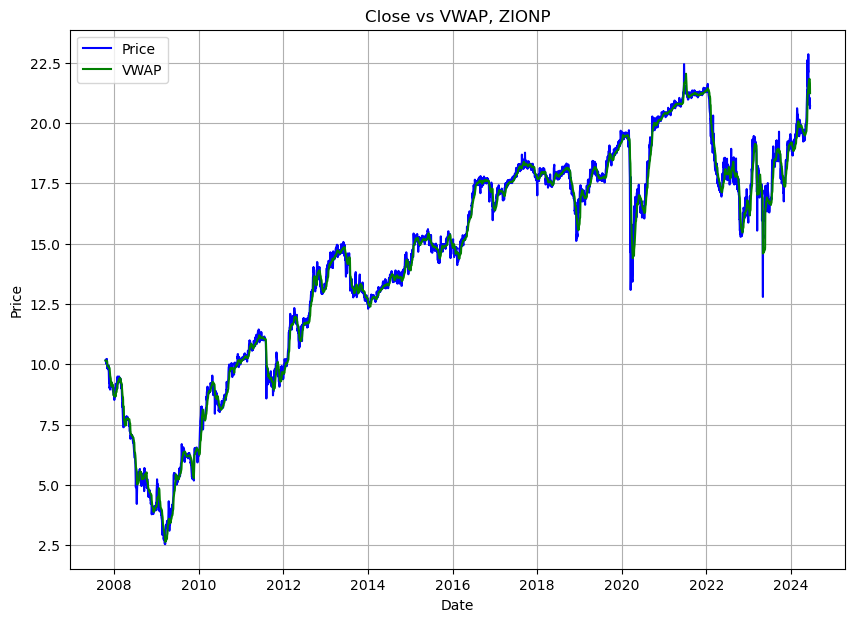

In [ ]:
# Create the plot
plt.figure(figsize=(10, 7))  # Set the figure size
plt.plot(df.index, df['Close'], label="Price", color = "blue")
plt.plot(df.index, df['vwap'], label="VWAP", color = 'green')
# Add labels and title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"Close vs VWAP, {ticker}")
# Add legend
plt.legend()
# Show the plot
plt.grid(True)
plt.show()